# Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nolitsa.nolitsa import data, delay, dimension, utils, lyapunov
from STPDP import STPDP
from SSRPC import SSRPC

# Generate data

In [2]:
sample = 0.01  # sampling period
x0 = [0.62225717, -0.08232857, 30.60845379]  # initial condition

# generate Lorenz system data
lorenz_x = data.lorenz(length=1000 + 15000, sample=sample, x0=x0, sigma=16.0, beta=4.0, rho=45.92)[1]
lorenz_x = lorenz_x[1000:, 0]  # use data after transient section

# STPDP demo

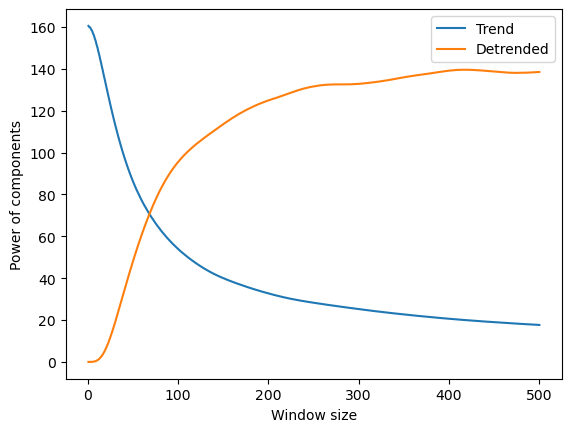

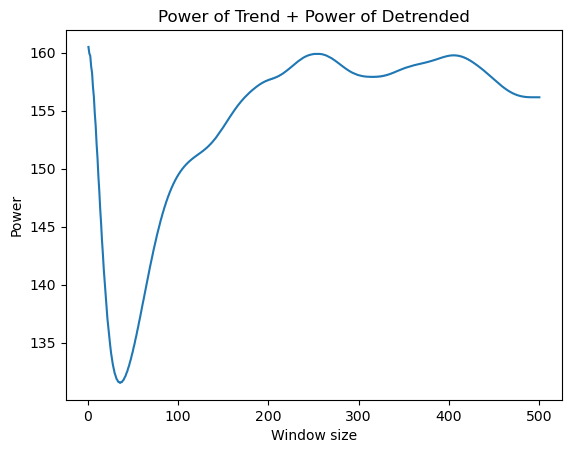

omega: 72


In [3]:
stpdp = STPDP(lorenz_x, max_length=500)
omega = stpdp.calculate_omega()
stpdp.plot()

# SSRPC demo

In [4]:
stpdp = STPDP(lorenz_x, max_length=500)
omega = stpdp.calculate_omega()
ssrpc = SSRPC(lorenz_x, sample, omega)
ssrpc.reconstruct()
ssrpc.calculate_divergence(maxt=500)

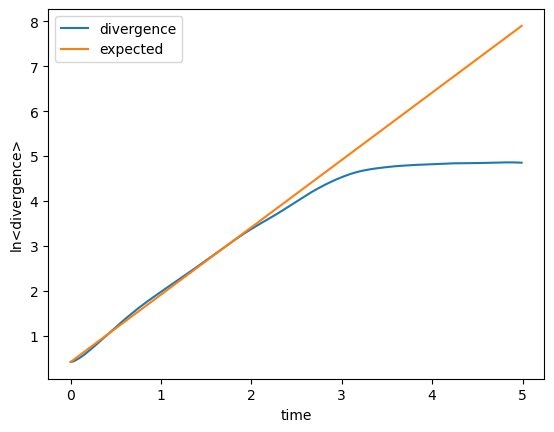

In [5]:
ssrpc.plot_divergence(expected=1.5)

In [6]:
mle = ssrpc.mle((0, 200))
print(mle)

1.511023103625722


# Noise-robustness of SSRPC

In [7]:
# generate noisy data (SNR=10000 ~ 1)
signal = lorenz_x
signal_power = np.mean((signal - np.mean(signal))**2)

noisy_data_list = [signal]
for snr in [10000, 1000, 100, 10, 1]:
    noise = np.random.normal(0, np.sqrt(signal_power/snr), len(signal))
    noisy_data = signal + noise
    noisy_data_list.append(noisy_data)

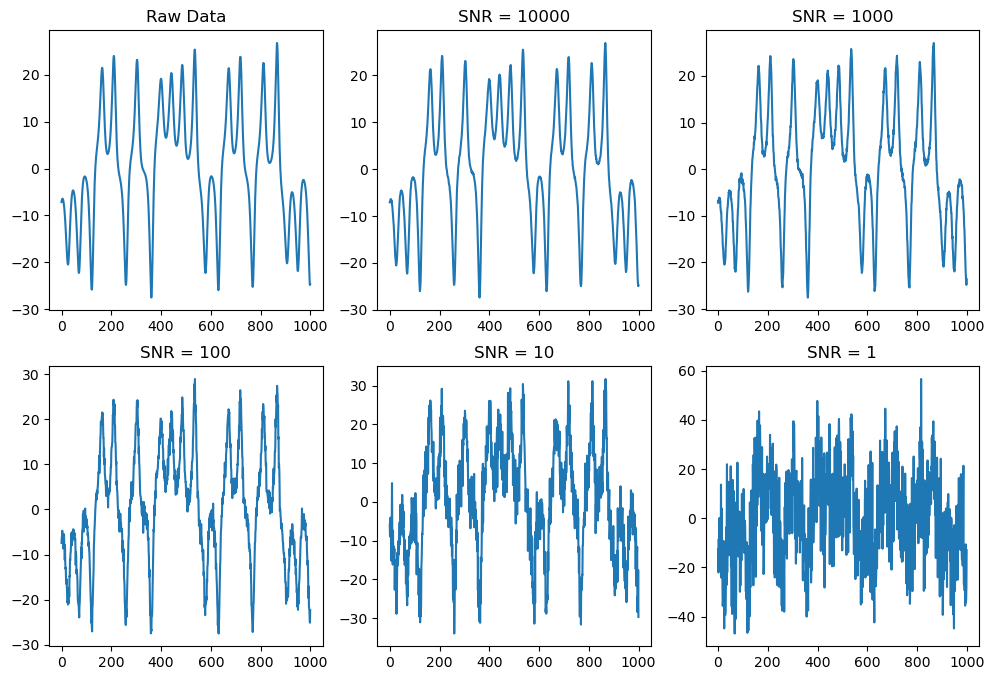

In [8]:
# see how noisy the data are
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)
ax4 = fig.add_subplot(2, 3, 4)
ax5 = fig.add_subplot(2, 3, 5)
ax6 = fig.add_subplot(2, 3, 6)

ax1.plot(noisy_data_list[0][:1000])
ax2.plot(noisy_data_list[1][:1000])
ax3.plot(noisy_data_list[2][:1000])
ax4.plot(noisy_data_list[3][:1000])
ax5.plot(noisy_data_list[4][:1000])
ax6.plot(noisy_data_list[5][:1000])

ax1.set_title("Raw Data")
ax2.set_title("SNR = 10000")
ax3.set_title("SNR = 1000")
ax4.set_title("SNR = 100")
ax5.set_title("SNR = 10")
ax6.set_title("SNR = 1")

plt.show()

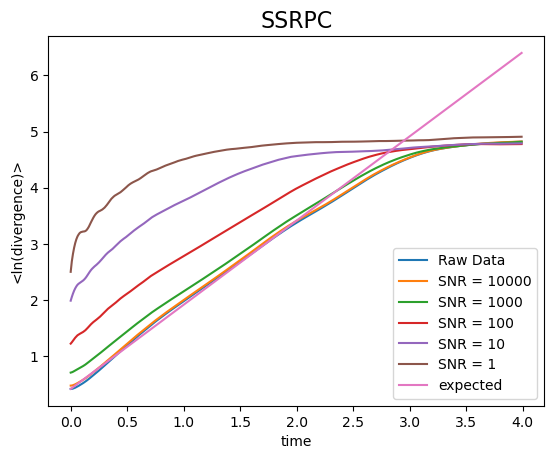

In [9]:
# SSRPC
divergence_list = []
for target_data in noisy_data_list:
    stpdp = STPDP(target_data, max_length=500)
    omega = stpdp.calculate_omega(start_limit=2)

    ssrpc = SSRPC(target_data, sample, omega)
    ssrpc.reconstruct()
    ssrpc.calculate_divergence(maxt=400)
    
    divergence_list.append(ssrpc.divergence)

plt.figure()
for i, label in enumerate(["Raw Data", "SNR = 10000", "SNR = 1000", "SNR = 100", "SNR = 10", "SNR = 1"]):
    plt.plot(ssrpc.time, divergence_list[i], label=label)
plt.plot(ssrpc.time, 1.5 * ssrpc.time + divergence_list[0][0], label="expected")
plt.legend()
plt.xlabel("time")
plt.ylabel('<ln(divergence)>')
plt.title("SSRPC", fontsize=16)
plt.show()

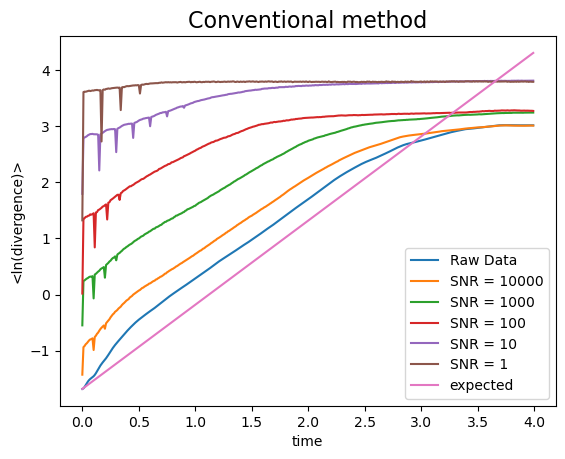

In [10]:
# Conventional method
divergence_list = []
for target_data in noisy_data_list:
    # set tau(time delay) by first minimum of AMI(Average Mutual Information)
    mi = delay.dmi(target_data, maxtau=500, bins=int((len(target_data)/5)**0.5))
    
    for i in range(100):
        if mi[i-1] > mi[i] and mi[i] < mi[i+1]:
            tau = i
            break
    
    # set embedding dimension by GFNN(Global False Nearest Neighbor)
    dim = np.arange(1, 10+1)
    f1, f2, f3 = dimension.fnn(target_data, tau=tau, dim=dim, metric='euclidean', R=17.0, A=2.0)
    for i in range(1, 10+1):
        if f3[i-1] < 0.01:
            embedding_dim = i
            break
    else:
        embedding_dim = np.where(f3 == f3.min())[0][0]
    
    reconstructed = utils.reconstruct(target_data, embedding_dim, tau)
    divergence = lyapunov.mle(reconstructed, maxt=400, window = 70)
    
    divergence_list.append(divergence)

time = np.arange(400 * sample, step=sample)
plt.figure()
for i, label in enumerate(["Raw Data", "SNR = 10000", "SNR = 1000", "SNR = 100", "SNR = 10", "SNR = 1"]):
    plt.plot(time, divergence_list[i], label=label)
plt.plot(time, 1.5 * ssrpc.time + divergence_list[0][0], label="expected")
plt.legend()
plt.xlabel("time")
plt.ylabel('<ln(divergence)>')
plt.title("Conventional method", fontsize=16)
plt.show()